In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from collections import Counter
from imblearn.under_sampling import RandomUnderSampler
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline

In [2]:
PATH_TO_CSV= 'data/processed/data.csv'  # Utilisation correcte du séparateur de chemin
R_STATE= 123

df = pd.read_csv(PATH_TO_CSV)
df.reset_index(drop=True, inplace=True)
df = df.drop(columns=['Unnamed: 0'])
df = df[df['grav'] != -1]


Counter({1: 155983, 4: 150770, 3: 57111, 2: 10263})


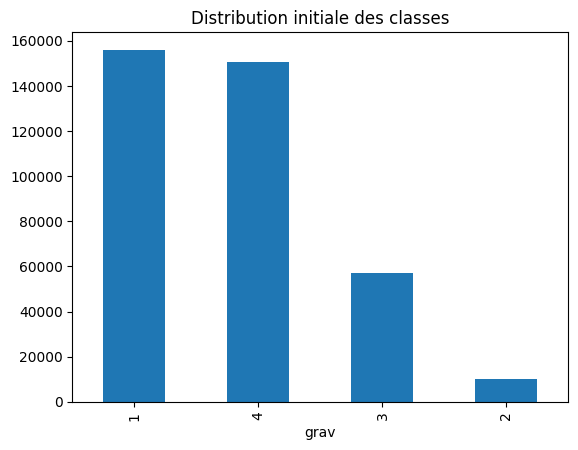

In [3]:
print(Counter(df['grav']))
df['grav'].value_counts().plot(kind='bar')
plt.title('Distribution initiale des classes')
plt.show()


Counter({1: 10263, 2: 10263, 3: 10263, 4: 10263})


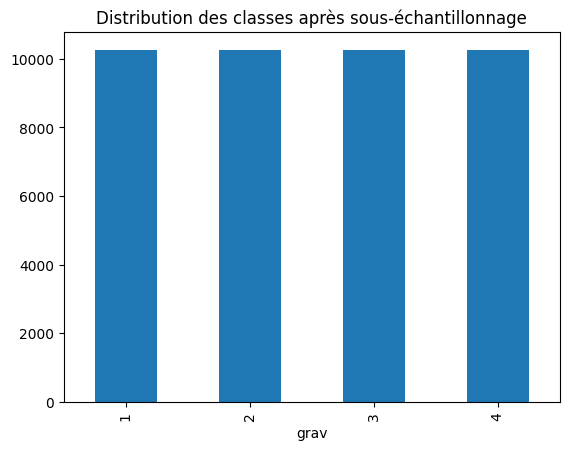

In [4]:
X = df.drop(columns=['grav'])
y = df['grav']

rus = RandomUnderSampler(random_state=R_STATE)
X_res, y_res = rus.fit_resample(X, y)

print(Counter(y_res))
pd.Series(y_res).value_counts().plot(kind='bar')
plt.title('Distribution des classes après sous-échantillonnage')
plt.show()


In [5]:
dummy_columns = ['lum', 'agg', 'int', 'atm', 'col', 'catr', 'circ', 'prof', 'place', 'catu', 'sexe', 
                 'trajet', 'secu1', 'secu2', 'secu3', 'locp', 'actp', 'etatp', 'senc', 'catv', 'obs', 
                 'obsm', 'choc', 'manv', 'motor', 'plan', 'surf','an','infra','dep','situ','vosp']
columns_to_scale = [col for col in X.columns if col not in dummy_columns]

scaler = StandardScaler()
X_scaled= scaler.fit_transform(X_res[columns_to_scale])

pca= PCA()
X_pca= pca.fit_transform(X_scaled)
variance= np.cumsum(pca.explained_variance_ratio_)
optimal_components= np.argmax(variance >= 0.95) + 1
print(f'Optimal components = {optimal_components}')

pca= PCA(n_components= optimal_components)
X_pca_optimal= pca.fit_transform(X_scaled)

Optimal components = 315


In [6]:
X_train, X_test, y_train, y_test = train_test_split(X_pca_optimal, y_res, test_size=0.2, random_state=R_STATE)

In [7]:
models = {
    'LogisticRegression': LogisticRegression(),
    'RandomForest': RandomForestClassifier(),
    'SVC': SVC(),
    'KNeighbors': KNeighborsClassifier()
}

params = {
    'LogisticRegression': {'C': [0.1, 1, 10]},
    'RandomForest': {'n_estimators': [50, 100, 200]},
    'SVC': {'C': [0.1, 1, 10], 'kernel': ['linear', 'rbf']},
    'KNeighbors': {'n_neighbors': [3, 5, 7]}
}

In [8]:
best_model = None
best_params = None
best_score = 0

for model_name in models:
    clf = models[model_name]
    param_grid = params[model_name]

    grid_search = GridSearchCV(clf, param_grid, cv=5, scoring='f1_weighted')
    grid_search.fit(X_train, y_train)

    if grid_search.best_score_ > best_score:
        best_score = grid_search.best_score_
        best_model = grid_search.best_estimator_
        best_params = grid_search.best_params_

print(f"Best Model: {best_model}")
print(f"Best Parameters: {best_params}")
print(f"Best Score: {best_score:.4f}")

E:\Telechargements\Datascientest\Git_GitHub\repos\Projet_Accidentologie\venv\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
E:\Telechargements\Datascientest\Git_GitHub\repos\Projet_Accidentologie\venv\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative sol

KeyboardInterrupt: 

In [ ]:
y_pred_best = best_model.predict(X_test)

accuracy_best = accuracy_score(y_test, y_pred_best)
report_best = classification_report(y_test, y_pred_best)

print(f"Precision: {accuracy_best:.2f}")
print(f"Report best model:\n{report_best}")